In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../data/raw/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Feature engineering
1. Columns PassengerId and Ticket are not relevant for prediction, so they will be removed from the dataset.
2. From the Cabin column, a new binary feature called Has_Cabin will be created to indicate whether a passenger had a cabin, as this could be associated with a higher chance of survival.
3. From the Name column, a new feature called Title will be extracted. This feature will be used to help impute missing values in the Age column by grouping passengers with similar characteristics.
4. Missing values in the Embarked column will be filled using the mode, since it is a categorical feature with only a small number of missing values.
5. From the Parch and SibSp columns, a new feature called FamilySize will be created to represent the total number of family members traveling with each passenger.

In [6]:
df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [7]:
df['Has_Cabin'] = df['Cabin'].notna().astype(int)
df.drop('Cabin', axis=1, inplace=True)
df.groupby('Has_Cabin')['Survived'].mean()

Has_Cabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64

In [8]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)', expand=True)
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
df['Title'] = df['Title'].apply(lambda x: x if x in common_titles else 'Rare')
df.drop('Name', axis=1, inplace=True)
df['Title'].value_counts()


Title
Mr        502
Miss      179
Mrs       121
Rare       49
Master     40
Name: count, dtype: int64

In [9]:
df.groupby('Title')['Age'].mean()

Title
Master     4.574167
Miss      21.846154
Mr        32.389610
Mrs       36.182692
Rare      36.597826
Name: Age, dtype: float64

In [10]:
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('mean'))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [11]:
df.isnull().sum()

Survived     0
Pclass       0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         0
Embarked     0
Has_Cabin    0
Title        0
dtype: int64

In [16]:
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
df.drop(['Parch', 'SibSp'], axis=1, inplace=True)

### Feautre binning and encoding
1. The Age column will be grouped into age groups to better capture the non-linear relationship between age and survival.
2. One-hot encoding will be applied to the Embarked, Title, and Sex columns to convert categorical variables into a numerical format suitable for machine learning models.

<Axes: xlabel='AgeGroup', ylabel='Survived'>

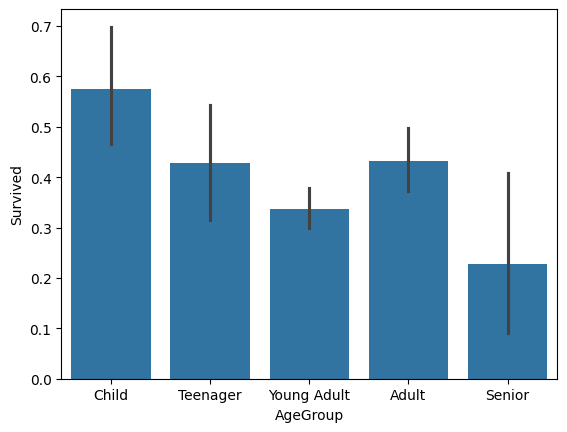

In [13]:
bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=age_labels)
df.drop('Age', axis=1, inplace=True)

sns.barplot(df, x='AgeGroup', y='Survived')

In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

preprocessor = ColumnTransformer(transformers=[
    ('age_ord', OrdinalEncoder(categories=age_labels), ['AgeGroup']),
    ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['Sex', 'Embarked', 'Title'])
], remainder='passthrough')

In [ ]:
df.to_csv("../data/processed/train_cleaned.csv", index=False)